In [28]:
from PIL import Image
import numpy as np

import matplotlib

import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16, 10)
matplotlib.rcParams.update({'font.size': 18})

In [74]:
# img = Image.open('demo/ocean_pano.jpg')
img = Image.open('demo/beach-ocean-panorama-187916.jpg')

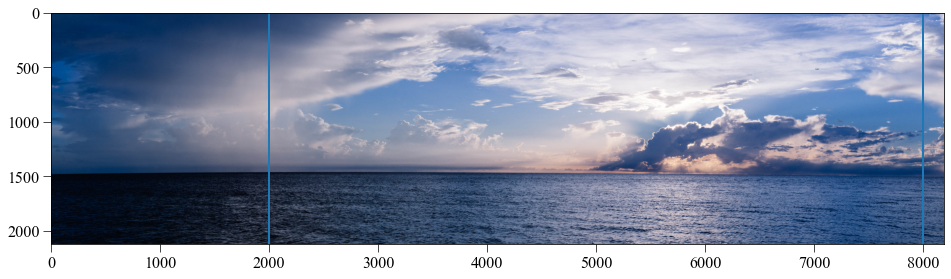

In [75]:
plt.imshow(img)
plt.axvline(x=2000)
plt.axvline(x=8000)
plt.show()

In [76]:
arry = img.getdata()

In [77]:
im_arr = np.fromstring(img.tobytes(), dtype=np.uint8)
im_arr = im_arr.reshape((img.size[1], img.size[0], 3)) 

/var/folders/bt/hcx3fsms41nfk08g1d3xy8t40000gn/T/ipykernel_47054/3829475553.py:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  im_arr = np.fromstring(img.tobytes(), dtype=np.uint8)


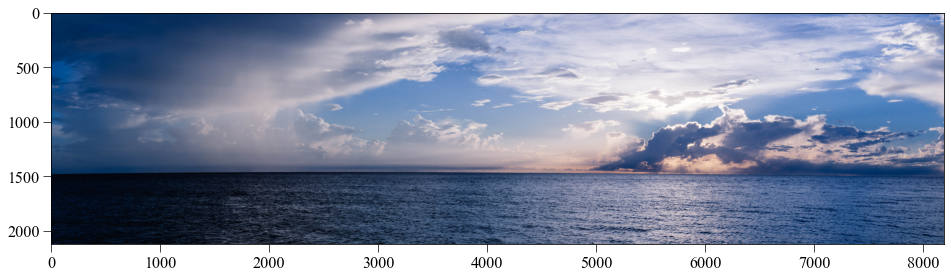

In [78]:
plt.imshow(im_arr)
plt.show()

In [118]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [119]:
pix_list = im_arr.reshape((im_arr.shape[0] * im_arr.shape[1], im_arr.shape[2]))

In [120]:
pix_list.shape

(17408000, 3)

In [126]:
km = KMeans(n_clusters=2)
km.fit(pix_list[::10])

KMeans(n_clusters=2)

In [127]:
classed = km.predict(pix_list)

In [128]:
recon = classed.reshape(im_arr.shape[:2])

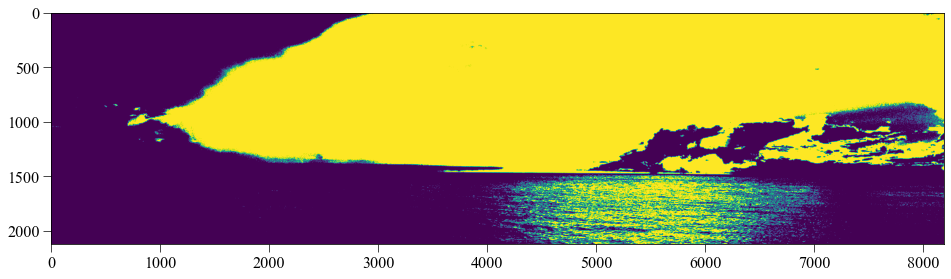

In [129]:
plt.imshow(recon)
plt.show()

/var/folders/bt/hcx3fsms41nfk08g1d3xy8t40000gn/T/ipykernel_47054/2546945504.py:1: RuntimeWarning: divide by zero encountered in log10
  grad = np.log10(abs(np.gradient(im_arr.sum(axis=2), axis=0)))


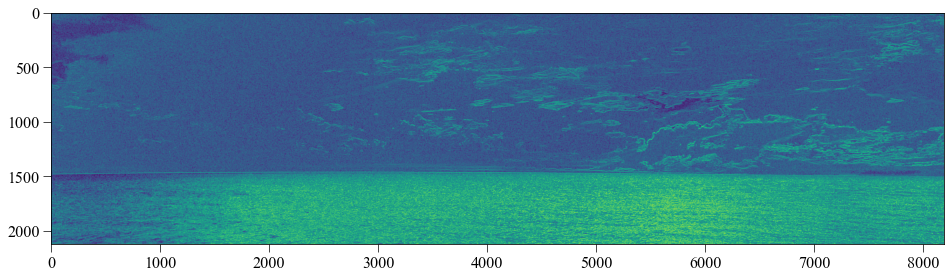

In [79]:
grad = np.log10(abs(np.gradient(im_arr.sum(axis=2), axis=0)))
grad[np.isinf(grad)] = 0
plt.imshow(grad)
# plt.colorbar()
plt.show()

In [21]:
from scipy.signal import savgol_filter

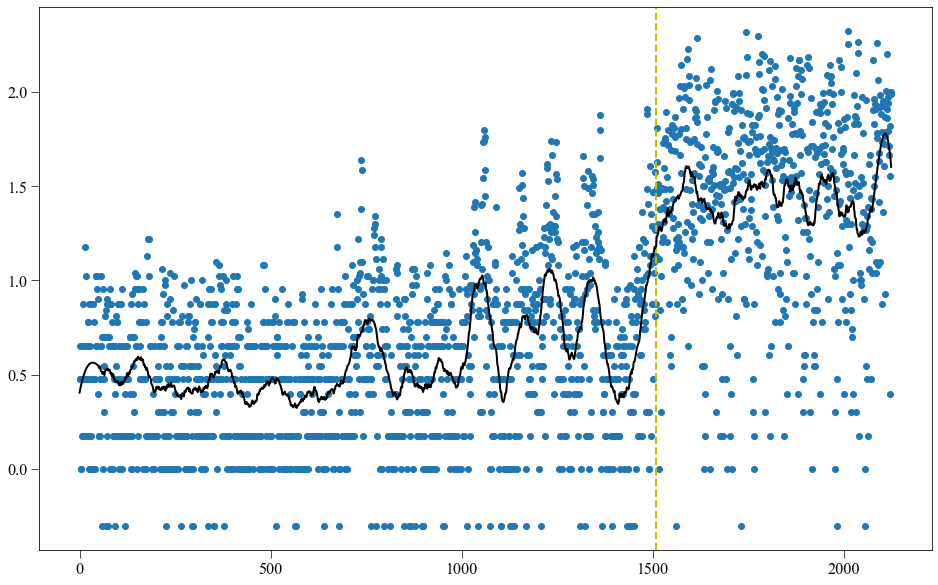

In [80]:
y = grad[:, 6000]
y[np.isinf(y)] = 0

yhat = savgol_filter(y, 101, 3)

yhathat = np.diff(yhat)
m = np.argmax(yhathat)

plt.axvline(x=m, c='y', ls='--')

plt.scatter(np.arange(grad.shape[0]), y)
plt.plot(np.arange(grad.shape[0]), yhat, c='k')

plt.show()

In [133]:
# def find_break(image, buffer=1500):
    
#     breaks = []
#     for i in range(image.shape[1]):
    
#         y = grad[:, i]
#         y[np.isinf(y)] = 0

#         yhat = savgol_filter(y, 101, 3)

#         yhathat = np.diff(yhat)
#         m = np.argmax(yhathat[buffer:-(buffer+300)])
# #         m = np.argmax(yhathat)

#         breaks += [m+buffer]
        
#     return np.array(breaks)

def find_break(image, y_min=0, y_max=-1):        
    
    breaks = []
    for i in range(image.shape[1]):
    
        y = grad[:, i]
        y[np.isinf(y)] = 0

        yhat = savgol_filter(y, 101, 3)

        yhathat = np.diff(yhat)
        m = np.argmax(yhathat[y_min:y_max])
#         m = np.argmax(yhathat)

        breaks += [m+y_min]
        
    return np.array(breaks)

# breaks = find_break(grad)
breaks = find_break(grad, y_min=1510, y_max=1550)

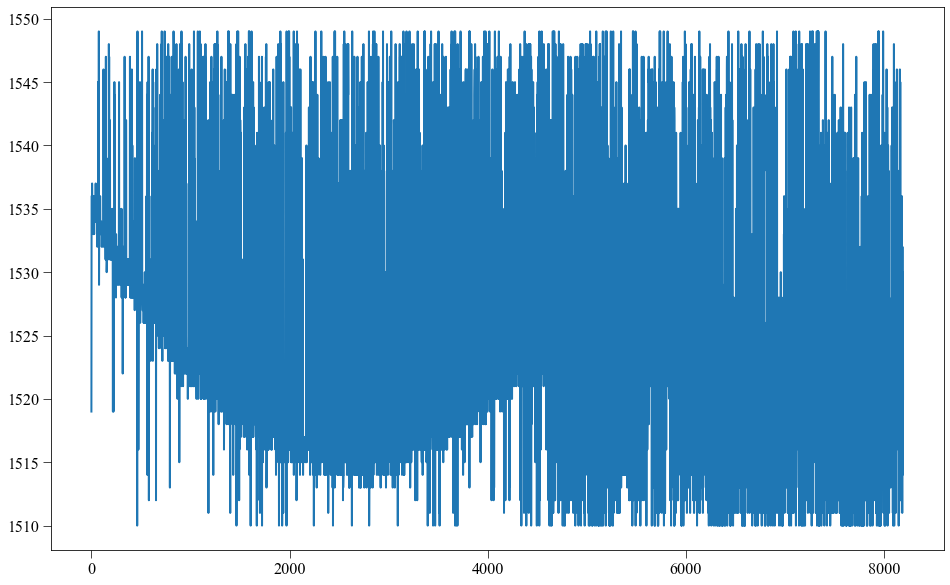

In [134]:
# plt.imshow(grad)
plt.plot(np.arange(grad.shape[1]), breaks)
plt.show()

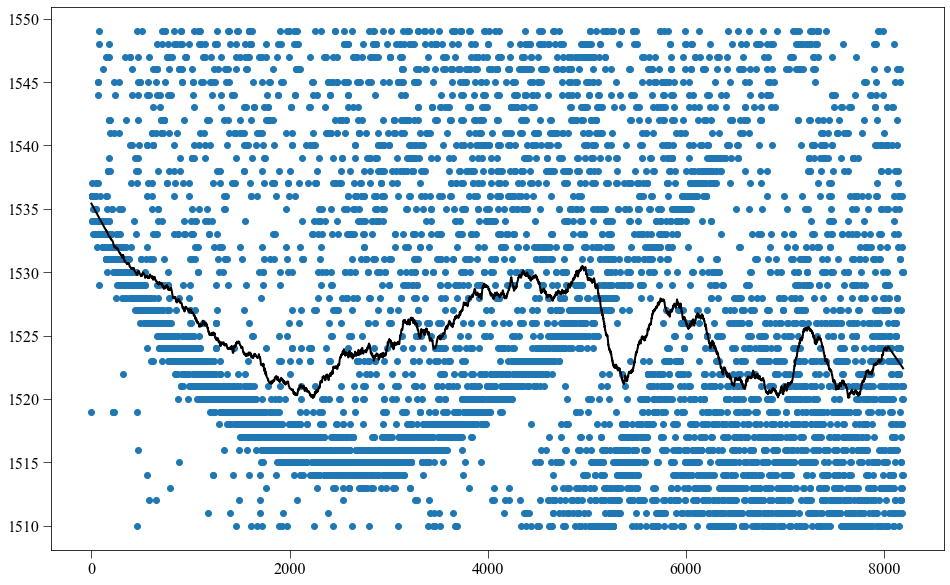

In [158]:
y = breaks.copy()

# yhat = savgol_filter(y, 901, 1)
yhat = savgol_filter(y, 301, 1)


plt.scatter(np.arange(grad.shape[1]), y)
plt.plot(np.arange(grad.shape[1]), yhat, c='k')

plt.show()

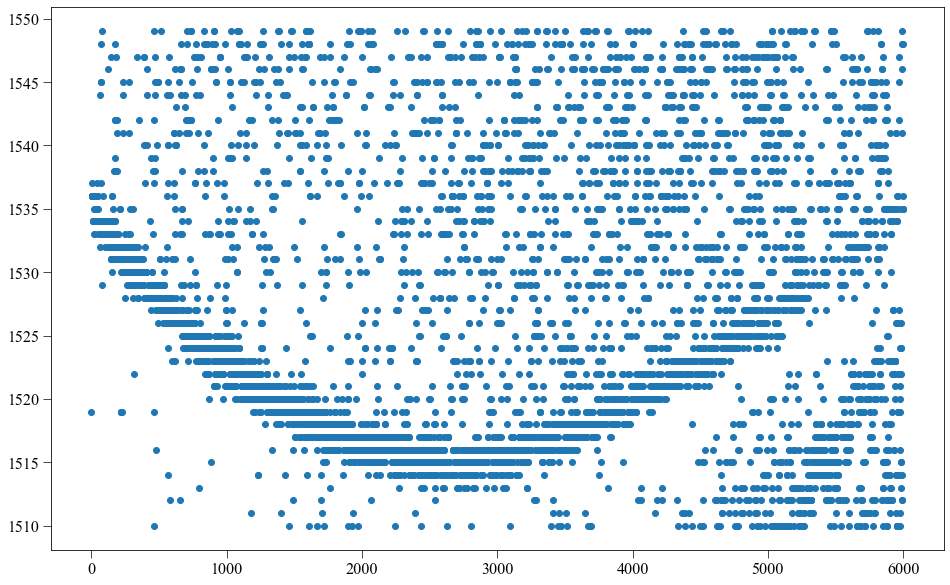

In [138]:
# cut = breaks[(breaks < 1920) & (breaks > 1780)][2000:8000]
cut = breaks[:6000]
plt.scatter(np.arange(len(cut)), cut)
plt.show()

In [111]:
cut = breaks

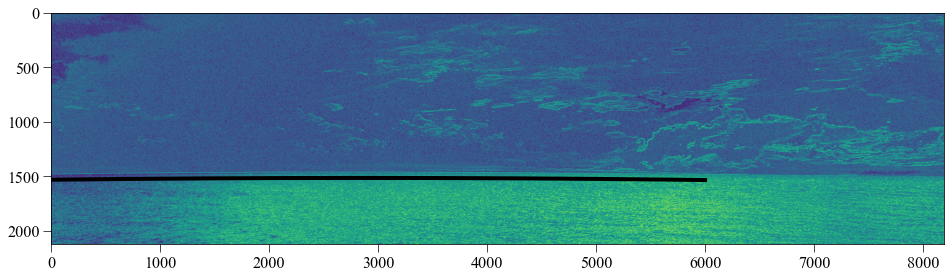

In [189]:
plt.imshow(grad)
coeff, cov = np.polyfit(np.arange(len(cut)), cut, 2, cov=True)
# coeff[0] = 0
coeff = [2e-6, -1.15e-2, 1.532e3]
y_fit = np.poly1d(coeff)(np.arange(len(cut)))

# plt.scatter(np.arange(len(cut))+2000, cut)
# plt.plot(np.arange(len(cut))+2000, y_fit, c='k', lw=4)
plt.plot(np.arange(len(cut)), y_fit, c='k', lw=4)
plt.show()

In [159]:
coeff

array([ 6.29329456e-07, -3.91791683e-03,  1.53037289e+03])

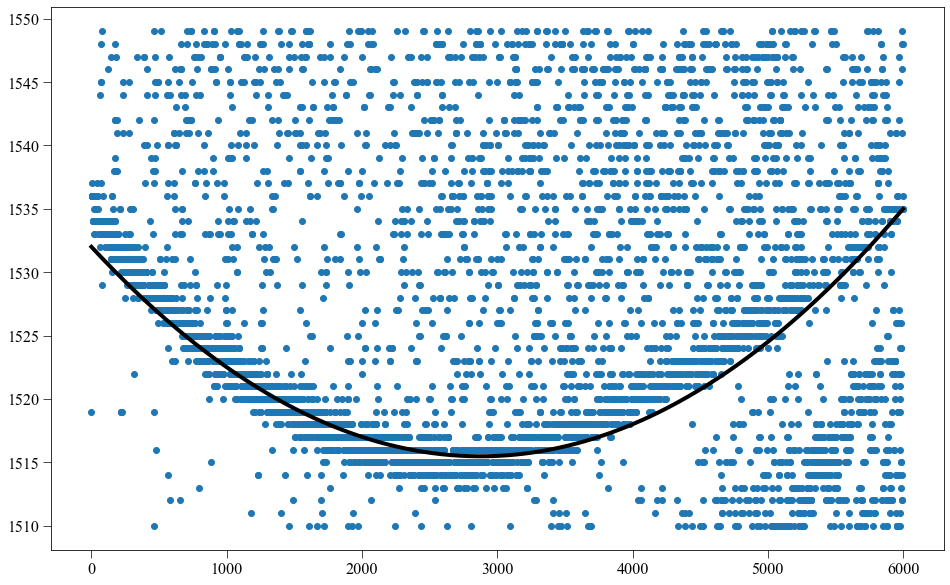

In [188]:
plt.scatter(np.arange(len(cut)), cut)
# plt.plot(np.arange(len(cut)), y_fit, c='k', lw=4)
plt.plot(np.arange(len(cut)), np.poly1d([2e-6, -1.15e-2, 1.532e3])(np.arange(len(cut))), c='k', lw=4)
plt.show()

In [140]:
coeff, cov

(array([ 6.29329456e-07, -3.91791683e-03,  1.53037289e+03]),
 array([[ 2.43670382e-15, -1.46177862e-11,  1.46129136e-08],
        [-1.46177862e-11,  9.35401880e-08, -1.05204210e-04],
        [ 1.46129136e-08, -1.05204210e-04,  1.57793167e-01]]))

In [141]:
grad.shape[0] - coeff[-1]

594.6271074008232

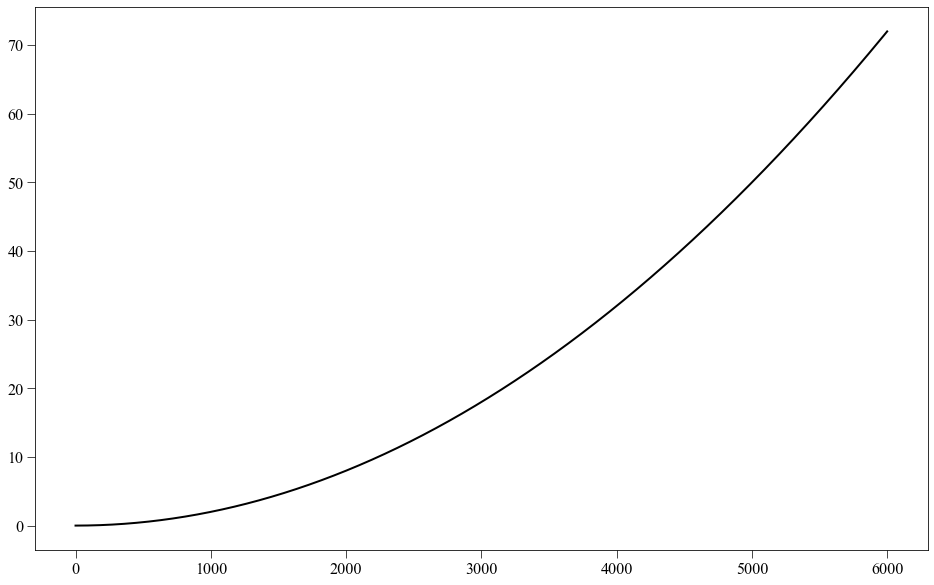

In [190]:
flat = coeff.copy()
flat[1] = 0
flat[2] = 0
y_fit = np.poly1d(flat)(np.arange(len(cut)))

plt.plot(np.arange(len(cut)), y_fit, c='k')
plt.show()

In [192]:
# number of pixels lost over the fit range with just the curvature component
min(y_fit)
max(y_fit)

71.976002

In [ ]:
# if we are losing 35 for every 6k pixels, we just need to know how far 6k pixels is


In [ ]:
# easy to get how many pixels it takes to go round the world, but km?

In [195]:
th = np.tan(abs(max(abs(y_fit)) / len(y_fit)))
th

0.011996575790697555

In [196]:
angle = th / 6000

26300


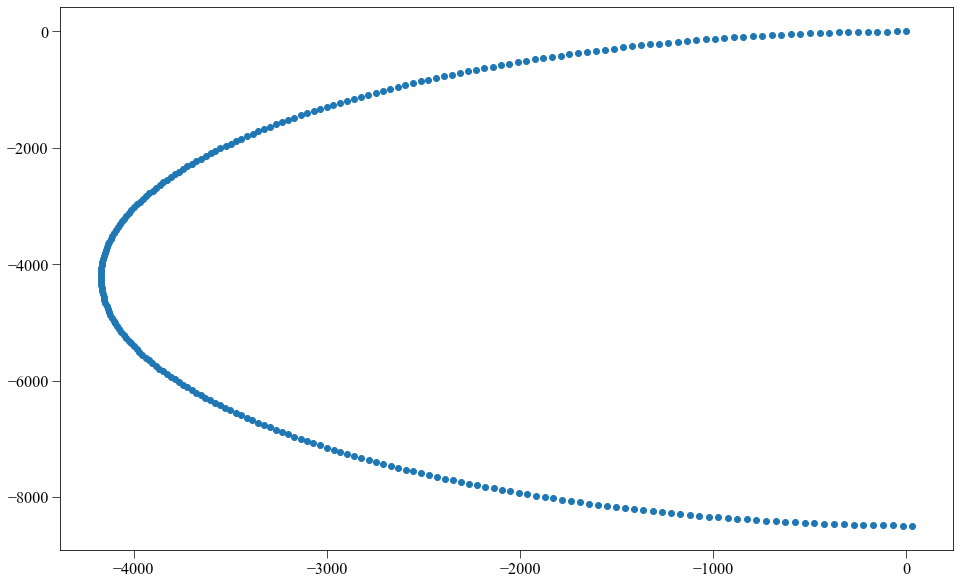

In [200]:
coords, circ = step_rad(stepsize=50, angle=angle)
print(circ)

plt.scatter(coords[:, 0], coords[:, 1])
plt.show()

In [44]:
th = np.arctan(0.006)
th

0.00599992800155516

In [45]:
0.006*5 * np.sin(th)

0.0001799967600874774

In [67]:
th*20 * np.sin(th)

0.0007002895853529242

In [46]:
6000 * 1e-6

0.006

5190
21200


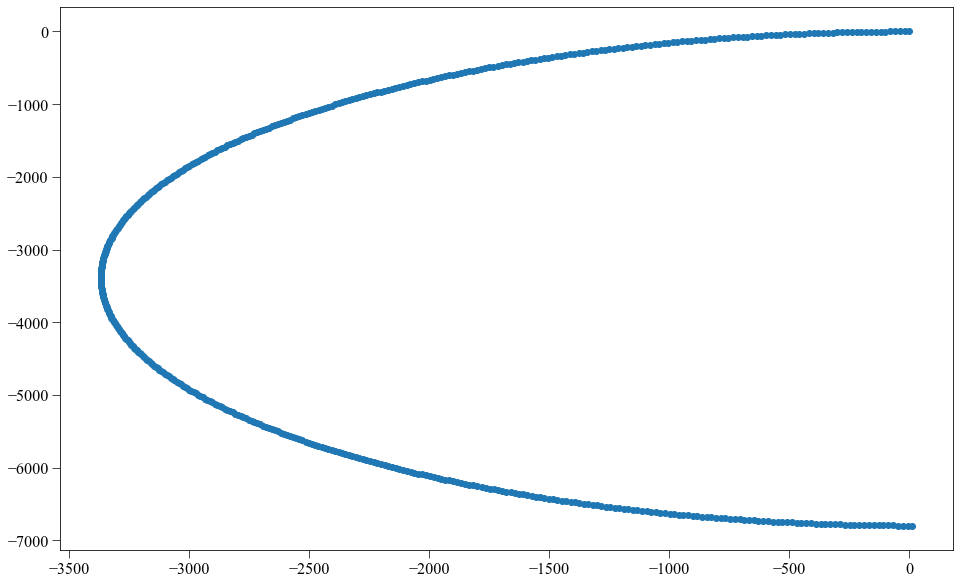

In [49]:
def step_rad(stepsize=5, angle=1e-6):
    
    d1 = 6000 * angle
    
    dev = d1 * stepsize
    
    coords = [[0, 0]]
    adj = coords[-1].copy()
    adj[0] -= stepsize
    adj[1] -= dev
    coords += [adj]
        
#     for i in range(1, n_steps):
        
    i = 0
    while coords[-1][0] < 0:
        i += 1
        prev = coords[i - 1].copy()
        current = coords[i].copy()
        dy = (current[1] - prev[1])
        dx = (current[0] - prev[0])
        
        midpoint = [prev[0] + 2*dx, prev[1] + 2*dy]
        
        m = dy / dx
        a = -1. / m
        
        th = np.arctan(a)
        dy2 = dev * np.sin(th)
        dx2 = dev * np.cos(th)
        
        next_point = [midpoint[0] + dx2, midpoint[1] + dy2]
        
        coords += [next_point]
    
    return np.array(coords), len(coords) * stepsize * 2

coords, circ = step_rad(stepsize=5, angle=1.01e-6)
print(circ)
coords, circ = step_rad(stepsize=20, angle=0.99e-6)
print(circ)

plt.scatter(coords[:, 0], coords[:, 1])
plt.show()